# 有限元算例稳态Navier-Stokles方程Newton方法求解
本节将引导您使用 FEALPy.CFD 完成稳态的 Navier-Stokes 方程的 Newton 方法的有限元求解，现定义如下数学模型：
$$\begin{cases} -\nu \Delta \boldsymbol{u} + (\boldsymbol{u} \cdot \nabla)\boldsymbol{u} + \nabla p = \boldsymbol{f} & \text{in } \Omega, \\ \nabla \cdot \boldsymbol{u} = 0 & \text{in } \Omega, \\ \boldsymbol{u} = 0 & \text{on } \partial \Omega, \end{cases}$$
$$\int_{\Omega} p \, dx = 0,$$
其中：
- $\boldsymbol{u}$ 表示速度场，
- $p$ 表示压力，
- $\nu$ 为运动粘性系数，
- $\boldsymbol f$为外力，
- $\Omega$为计算区域。

我们定义真解为
$$\boldsymbol u = (u_1, u_2) $$
$$ u_1 = 10x^2(x-1)^2 y (y-1) (2y-1), u2 = -10x(x-1)(2x-1)y^2(y-1)^2 $$
$$ p = 10(2x-1)(2y-1)$$

## 1.定义PDE类型

In [15]:
from fealpy.decorator import cartesian
from fealpy.backend import backend_manager as bm
from fealpy.backend import TensorLike
from fealpy.mesher import BoxMesher2d
import sympy as sp
class Exp0001(BoxMesher2d): 
    def __init__(self, options: dict = {}):
        self.options = options
        self.box = [0.0, 1.0, 0.0, 1.0]
        self.eps = 1e-10
        self.mu = 1.0
        self.rho = 1.0
        self._init_expr()
        super().__init__(box=self.box)
    
    @cartesian
    def velocity(self, p: TensorLike) -> TensorLike:
        """Compute exact solution of velocity."""
        x = p[..., 0]
        y = p[..., 1]
        result = bm.zeros(p.shape, dtype=bm.float64)
        result[..., 0] = bm.array(self.u(x, y)[0])
        result[..., 1] = bm.array(self.u(x, y)[1])
        return result
    
    @cartesian
    def pressure(self, p: TensorLike) -> TensorLike:
        """Compute exact solution of pressure."""
        x = p[..., 0]
        y = p[..., 1]
        return bm.array(self.p(x, y))
    
    @cartesian
    def source(self, p: TensorLike) -> TensorLike:
        x = p[..., 0]
        y = p[..., 1]
        result = bm.zeros(p.shape, dtype=bm.float64)
        result[..., 0] = bm.array(self.force(x, y)[0])
        result[..., 1] = bm.array(self.force(x, y)[1])
        return result

    @cartesian
    def is_velocity_boundary(self, p: TensorLike) -> TensorLike:
        return None

    @cartesian
    def is_pressure_boundary(self, p: TensorLike) -> TensorLike:
        result = bm.zeros_like(p[..., 0], dtype=bm.bool)
        return result

    @cartesian
    def velocity_dirichlet(self, p: TensorLike) -> TensorLike:
        return self.velocity(p)
    
    @cartesian
    def pressure_dirichlet(self, p: TensorLike) -> TensorLike:
        return self.pressure(p)

    def _init_expr(self):
        """Initialize symbolic expressions for velocity, pressure, and source."""
        x, y = sp.symbols('x, y')
        u1 = 10 * x ** 2 * (x - 1) ** 2 * y * (y - 1) * (2 * y - 1)
        u2 = -10 * x * (x - 1) * (2 * x - 1) * y ** 2 * (y - 1) ** 2
        p = 10 * (2 * x - 1) * (2 * y - 1)
        mu = self.mu
        rho = self.rho
        u = sp.Matrix([u1, u2])
        gradu1x = u1.diff(x)
        gradu1y = u1.diff(y)
        gradu2x = u2.diff(x)
        gradu2y = u2.diff(y)

        # 不可压缩性
        assert sp.simplify(gradu1x + gradu2y) == 0  

        convection = sp.Matrix([u1 * gradu1x + u2 * gradu1y, u1 * gradu2x + u2 * gradu2y])
        diffusion = sp.Matrix([sp.diff(gradu1x, x) + sp.diff(gradu1y, y), sp.diff(gradu2x, x) + sp.diff(gradu2y, y)])
        gradp = sp.Matrix([p.diff(x), p.diff(y)])
        force = - mu*diffusion + rho*convection + gradp
        
        self.u = sp.lambdify([x, y], u, 'numpy')
        self.p = sp.lambdify([x, y], p, 'numpy')
        self.force = sp.lambdify([x, y], force, 'numpy')



## 2. 进行参数配置和初始化

设置后端

In [16]:
from fealpy.backend import backend_manager as bm

backend = 'numpy'
device = 'cpu'
bm.set_backend(backend)

导入日志工具

In [17]:
from fealpy.utils import timer
from fealpy import logger

logger.setLevel('WARNING')
tmr = timer()
next(tmr)

定义求解参数

In [18]:
tol = 1e-10
maxstep = 10
maxit = 4

定义误差存储矩阵

In [19]:
u_errorMatrix = bm.zeros((1, maxit), dtype=bm.float64)
p_errorMatrix = bm.zeros((1, maxit), dtype=bm.float64)

## 3.有限元求解

流程包含：

- 构建求解方程的equation以及求解方法fem

- 设置速度和压力的空间

- 组装刚度矩阵 $A$ 和载荷向量 $F$

- 处理Dirichlet边界条件

- 求解线性系统 $A u_h = F$

- 计算L2误差 $\|u - u_h\|_{L^2(\Omega)}$

- 网格均匀加密

In [20]:
from fealpy.cfd.equation.stationary_incompressible_ns import StationaryIncompressibleNS
from fealpy.cfd.simulation.fem.stationary_incompressible_ns import Newton
from fealpy.solver import spsolve

tol = 1e-10
maxstep = 10
pde = Exp0001()
equation = StationaryIncompressibleNS(pde)
mesh = pde.init_mesh['uniform_tri'](nx=4, ny=4)
fem = Newton(equation, mesh)
fem.set.uspace('Lagrange', p=2)
fem.set.pspace('Lagrange', p=1)

for i in range(maxit):
    uh0 = fem.uspace.function()
    ph0 = fem.pspace.function()
    uh1 = fem.uspace.function()
    ph1 = fem.pspace.function()
    
    BForm  = fem.BForm()
    LForm  = fem.LForm()
    ugdof = fem.uspace.number_of_global_dofs()
    for _ in range(maxstep): 
        fem.update(uh0)
        A = BForm.assembly()
        b = LForm.assembly()

        A, b = fem.apply_bc(A, b, pde)
        A, b = fem.lagrange_multiplier(A, b)

        x = spsolve(A, b, 'mumps')
        uh1[:] = x[:ugdof]
        ph1[:] = x[ugdof:-1]
        res_u = mesh.error(uh0, uh1)
        res_p = mesh.error(ph0, ph1)
        if res_u + res_p < tol:
            print(f"Converged at iteration {i+1}")
            print("res_u =", res_u)
            print("res_p =", res_p)
            break
        uh0[:] = uh1
        ph0[:] = ph1
    u_errorMatrix[0, i] = mesh.error(uh1, pde.velocity)
    p_errorMatrix[0, i] = mesh.error(ph1, pde.pressure)
    if i < maxit - 1:
        mesh.uniform_refine()
        fem.update_mesh(mesh)


Converged at iteration 1
res_u = 1.3145797537238003e-13
res_p = 1.4155478714962116e-11
Converged at iteration 2
res_u = 4.3191010376435233e-14
res_p = 8.97843522794632e-12
Converged at iteration 3
res_u = 2.358372421942251e-14
res_p = 1.0132305820554858e-11
Converged at iteration 4
res_u = 2.4080378995152098e-14
res_p = 1.0199398917828257e-11


## 4.误差分析和收敛阶计算

In [21]:
next(tmr)
print("速度最终误差",u_errorMatrix)
print("order : ", bm.log2(u_errorMatrix[0,:-1]/u_errorMatrix[0,1:]))
print("压力最终误差",p_errorMatrix)  
print("order : ", bm.log2(p_errorMatrix[0,:-1]/p_errorMatrix[0,1:]))


Timer received None and paused.
   ID       Time        Proportion(%)    Label
-------------------------------------------------
速度最终误差 [[1.87952236e-03 2.05935706e-04 2.32700663e-05 2.80719074e-06]]
order :  [3.19010018 3.14564677 3.05127632]
压力最终误差 [[0.1625292  0.04039637 0.01008773 0.00252153]]
order :  [2.00840133 2.00162386 2.00022969]


## 5.结果可视化
在单元重心处计算真解和数值解，并进行可视化比较

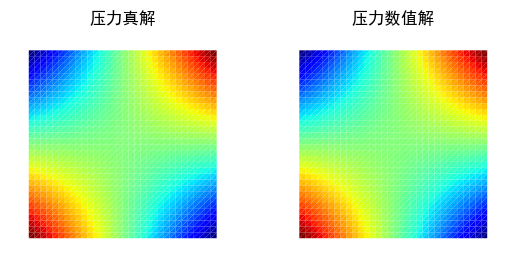

In [25]:
from matplotlib import pyplot as plt

bc = bm.array([[1/3, 1/3, 1/3]], dtype=bm.float64)
ps = mesh.bc_to_point(bc)
p = pde.pressure(ps)
ph = ph1(bc)

fig, axes = plt.subplots(1, 2)
mesh.add_plot(axes[0], cellcolor=p, linewidths=0)
axes[0].set_title('压力真解')
mesh.add_plot(axes[1], cellcolor=ph, linewidths=0)
axes[1].set_title('压力数值解')

plt.show()
